In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm.auto import tqdm

In [3]:
pd.set_option("max_rows", None)

In [4]:
def smoothing(data):
    data = data.reset_index(drop=True)
    series = data
    # Tail-rolling average transform
    rolling = series.rolling(window=8)
    rolling_mean = rolling.mean()
    return rolling_mean
    

In [5]:
def fullDay(data):
        """
           trimming an individual's glucose values to only consist of full days     
            Input:
                data: irregular time series
            Output:
                data: time series with data only for full days
        """ 
        
        dates = list()
        data = data.reset_index(drop=True)
        for i in range(0,len(data.index)):
            dates.append(data['Display Time'][i].date())
        data['Dates'] = dates
        end = data['Dates'].iloc[-1]
        start = data['Dates'].iloc[0]

        indexVals = data[ data['Dates'] == start ].index
        # indexVals
        data.drop(indexVals , inplace=True)

        indexVals = data[ data['Dates'] == end ].index
        # indexVals
        data.drop(indexVals , inplace=True)

        data = data.reset_index(drop=True)
        
        data.drop(['Dates'], axis=1, inplace=True)
        
        return data

In [6]:
#Extract Data
data = pd.read_csv("~/Desktop/NCSA_genomics/Python - notebooks/TSForecasting/Data/consolidatedDataForPackage.csv")
data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
#extracting data for individual 1636-69-032 
df = data[data['subjectId']=='ID32']
df = df.reset_index(drop=True)
#smoothening the data
df['GlucoseValue'] = smoothing(df['GlucoseValue'])
df = df[df['GlucoseValue'].notna()]
df = df.reset_index(drop=True)
df = fullDay(df)
# df
length = df['Display Time'].iloc[-1]-df['Display Time'].iloc[0]
length = length.round("d")
days = length.days
print(days)

13


In [7]:
#extracting glucose values and incdices
glucs = df['GlucoseValue'].to_list()
indices = [1*i for i in range(len(glucs))]

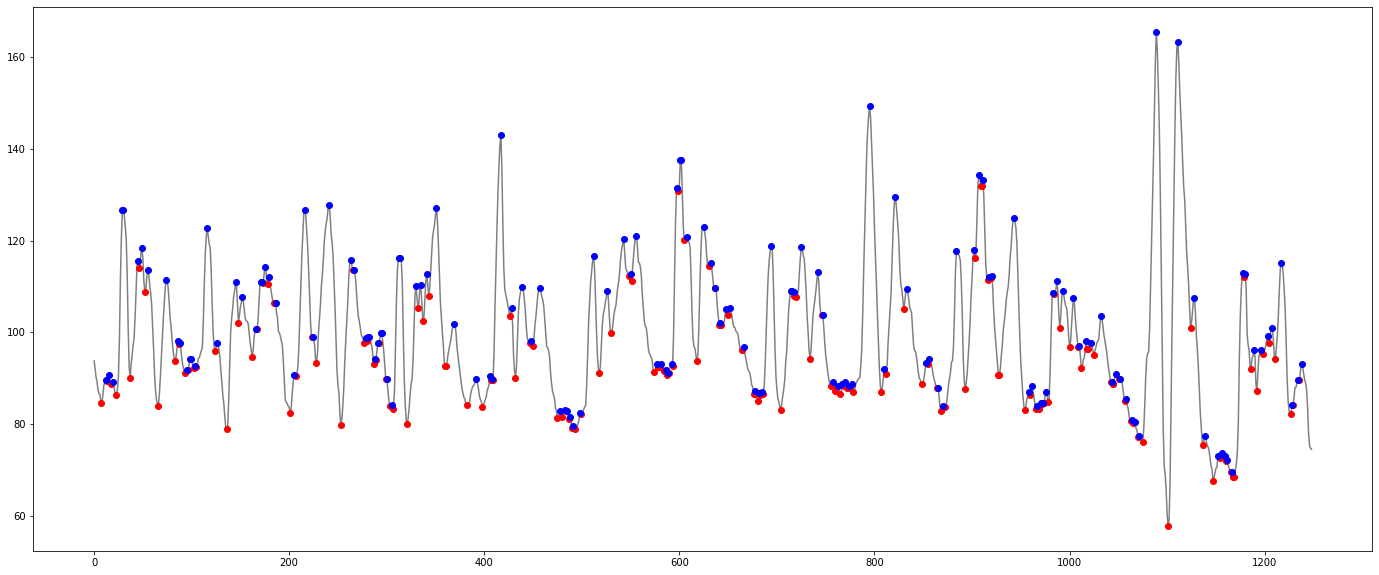

In [8]:

x = indices
gvs = glucs

# detection of local minima and maxima

# local min & max
a = np.diff(np.sign(np.diff(gvs))).nonzero()[0] + 1      
# local min
valleys = (np.diff(np.sign(np.diff(gvs))) > 0).nonzero()[0] + 1 
# local max
peaks = (np.diff(np.sign(np.diff(gvs))) < 0).nonzero()[0] + 1         
# +1 due to the fact that diff reduces the original index number


# plot
plt.figure(figsize=(24, 10))
plt.plot(x, gvs, color='grey')
for i in valleys:
    plt.plot(x[i], gvs[i], "o", label="min", color='r')
for i in peaks:
    plt.plot(x[i], gvs[i], "o", label="max", color='b')
plt.show()

In [9]:
print(len(peaks),len(valleys))



153 154


In [10]:
#storing the local minima and maxima to identify and remove turning points
excursion_points = pd.DataFrame(columns=['Index', 'Timestamp', 'GlucoseValue', 'Type'])
k=0
for i in range(len(peaks)):
    excursion_points.loc[k] = [peaks[i]] + [df['Display Time'][k]] + [df['GlucoseValue'][k]] + ["P"]
    k+=1

for i in range(len(valleys)):
    excursion_points.loc[k] = [valleys[i]] + [df['Display Time'][k]] + [df['GlucoseValue'][k]] + ["V"]
    k+=1

excursion_points = excursion_points.sort_values(by=['Index'])
excursion_points = excursion_points.reset_index(drop=True)
print("Excursion points:\n")
display(excursion_points)


# selecting turning points
stdev = 3
turning_points = pd.DataFrame(columns=['Index', 'Timestamp', 'GlucoseValue', 'Type'])
k=0
for i in range(stdev,len(excursion_points.Index)-stdev):
    positions = [i-stdev,i,i+stdev]
    for j in range(0,len(positions)-1):
        if(excursion_points.Type[positions[j]] == excursion_points.Type[positions[j+1]]):
            if(excursion_points.Type[positions[j]]=='P'):
                if excursion_points.GlucoseValue[positions[j]]>=excursion_points.GlucoseValue[positions[j+1]]:
                    turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                    k+=1
                else:
                    turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                    k+=1
            else:
                if excursion_points.GlucoseValue[positions[j]]<=excursion_points.GlucoseValue[positions[j+1]]:
                    turning_points.loc[k] = excursion_points.loc[positions[j]]
                    k+=1
                else:
                    turning_points.loc[k] = excursion_points.loc[positions[j+1]]
                    k+=1

    

if len(turning_points.index)<10:
    print(True)
    turning_points = excursion_points.copy()




turning_points = turning_points.drop_duplicates(subset= "Index", keep= "first")
turning_points = turning_points.reset_index(drop=True)
turning_points_count = len(turning_points.index)
print("Turning points:\n")
display(turning_points)

excursion_points = excursion_points[excursion_points.Index.isin(turning_points.Index) == False]
excursion_points = excursion_points.reset_index(drop=True)

Excursion points:



,Index,Timestamp,GlucoseValue,Type
0,7,2018-08-03 14:14:00,106.750,V
1,12,2018-08-02 00:00:00,93.750,P
2,13,2018-08-03 14:29:00,104.875,V
3,15,2018-08-02 00:15:00,92.250,P
4,17,2018-08-03 14:44:00,103.000,V
5,19,2018-08-02 00:30:00,90.250,P
6,22,2018-08-03 14:59:00,102.500,V
7,29,2018-08-02 00:45:00,89.250,P
8,30,2018-08-02 01:00:00,87.500,P
9,37,2018-08-03 15:14:00,102.375,V


Turning points:



,Index,Timestamp,GlucoseValue,Type
0,30,2018-08-02 01:00:00,87.500,P
1,37,2018-08-03 15:14:00,102.375,V
2,45,2018-08-02 01:15:00,86.625,P
3,99,2018-08-02 03:15:00,89.375,P
4,96,2018-08-03 16:59:00,98.750,V
5,103,2018-08-02 03:30:00,89.875,P
6,172,2018-08-02 05:15:00,87.375,P
7,167,2018-08-03 18:44:00,111.000,V
8,175,2018-08-02 05:30:00,86.250,P
9,178,2018-08-03 19:14:00,110.750,V


In [11]:
excursion_points

,Index,Timestamp,GlucoseValue,Type
0,7,2018-08-03 14:14:00,106.750,V
1,12,2018-08-02 00:00:00,93.750,P
2,13,2018-08-03 14:29:00,104.875,V
3,15,2018-08-02 00:15:00,92.250,P
4,17,2018-08-03 14:44:00,103.000,V
5,19,2018-08-02 00:30:00,90.250,P
6,22,2018-08-03 14:59:00,102.500,V
7,29,2018-08-02 00:45:00,89.250,P
8,46,2018-08-03 15:29:00,101.875,V
9,49,2018-08-02 01:30:00,86.500,P


In [12]:
# calculating the MAGE score
mage = turning_points.GlucoseValue.sum()/turning_points_count
print(mage)


100.59313725490196


In [13]:
mage_per_day = mage/days
print(mage_per_day)

7.737933634992459


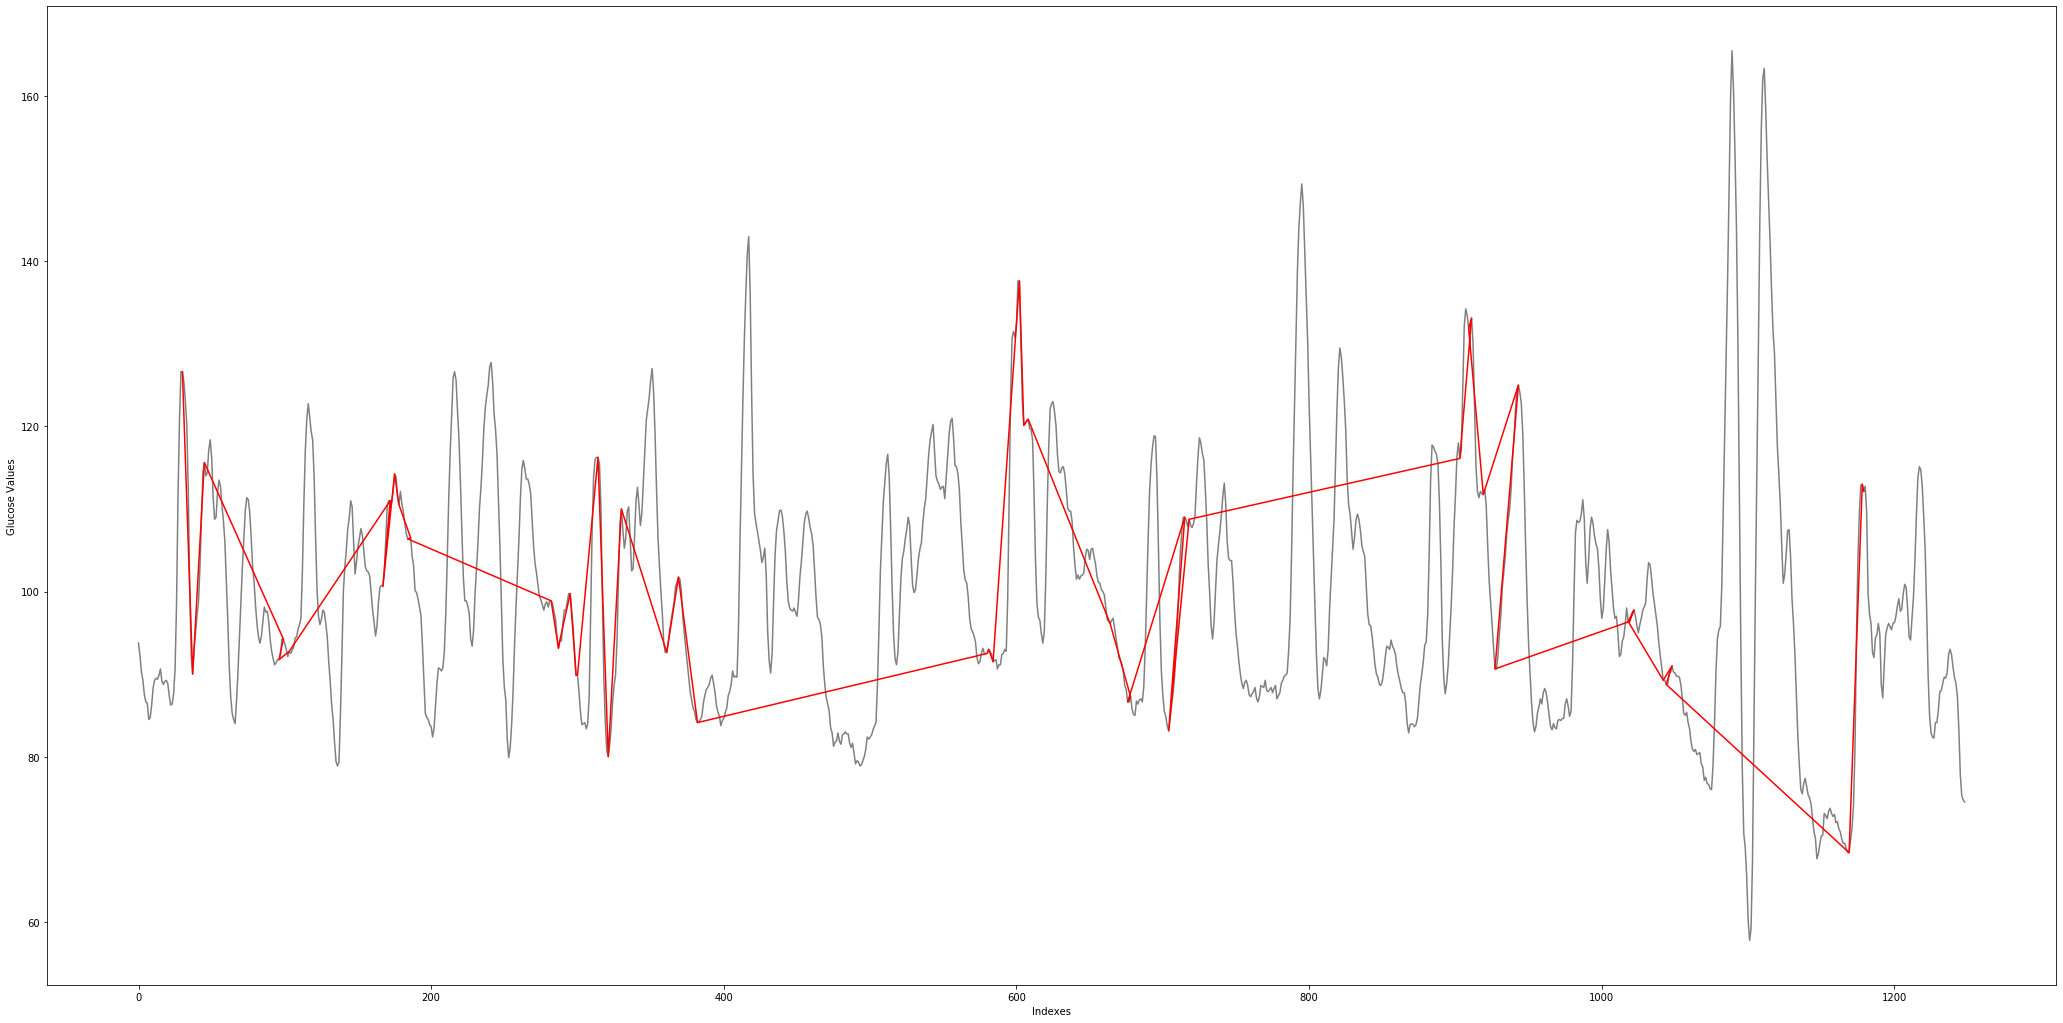

In [14]:
# plotting excusrion points
x = indices
gvs = glucs

fig = plt.figure(figsize=(36, 18))
plt.plot(x, gvs, color='grey')

plt.xlabel('Indexes')
plt.ylabel('Glucose Values')

a = []
b = []
for i in turning_points.Index:
    a.append(x[i])
    b.append(gvs[i])
#     plt.plot(x[i], gvs[i], "o", label="min", color='orange')

plt.plot(a,b,color="red")


    
    
    
    
    